In [ ]:
%load_ext tensorboard
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 41.3 MB/s eta 0:00:00


In [ ]:
import os

# Import installed libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import sklearn
from sklearn import preprocessing
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit

import tensorflow.keras as keras

In [ ]:
try:
    from google.colab import drive
    drive.mount('/gdrive')
    core_path = "/path name/"
except ModuleNotFoundError:
    core_path = ""

# Load the level 2 asteroid data
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

# Allocate the spectra to one array and the classes to another one
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main_Group"].to_list())

asteroids_X = np.expand_dims(asteroids_X, axis=2)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
label_encoder = preprocessing.OneHotEncoder(sparse=True)
asteroids_oh_y = label_encoder.fit_transform(asteroids_y.reshape(-1,1)).toarray()

# OK how are things encoded?
oh_init = [1, 0, 0, 0]
for n in range(4):
    oh_class = oh_init[-n:] + oh_init[:-n]
    org_class = label_encoder.inverse_transform([oh_class])
    print(f"One-Hot-Vector {oh_class} corresponds to the Main Group: {org_class[0][0]}")

# In this example we create a single test-training split with a ratio of 0.8 / 0.2
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):

    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_oh_y[train_index], asteroids_oh_y[test_index]

One-Hot-Vector [1, 0, 0, 0] corresponds to the Main Group: C
One-Hot-Vector [0, 1, 0, 0] corresponds to the Main Group: Other
One-Hot-Vector [0, 0, 1, 0] corresponds to the Main Group: S
One-Hot-Vector [0, 0, 0, 1] corresponds to the Main Group: X


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
sample_weight = compute_sample_weight("balanced", y=y_train)

In [ ]:
import keras_tuner as kt

# Early Stopping callback
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Get the number of inputs
n_inputs = asteroids_X.shape[1]

# We move our normalizer layers outside of the function
normalizer = keras.layers.Normalization(axis=1)
normalizer.adapt(X_train)

def create_model(hp):

    # Create now a simple Dense based network
    input_layer = keras.Input(shape=(n_inputs, 1))

    norm_layer = normalizer(input_layer)


    hidden_layer = keras.layers.Conv1D(filters=hp.Int("1st_filters",
                                                      min_value=8,
                                                      max_value=32,
                                                      step=8),
                                       activation="relu",
                                       kernel_size=hp.Int("1st_kernel_size",
                                                          min_value=3,
                                                          max_value=7,
                                                          step=1))(norm_layer)
    hidden_layer = keras.layers.MaxPooling1D(pool_size=2)(hidden_layer)

    hidden_layer = keras.layers.Conv1D(filters=hp.Int("2nd_filters",
                                                      min_value=16,
                                                      max_value=128,
                                                      step=16),
                                       activation="relu",
                                       kernel_size=hp.Int("2nd_kernel_size",
                                                          min_value=3,
                                                          max_value=7,
                                                          step=1))(norm_layer)
    hidden_layer = keras.layers.MaxPooling1D(pool_size=2)(hidden_layer)

    hidden_layer = keras.layers.Flatten()(hidden_layer)
    hidden_layer = keras.layers.Dense(hp.Int("units", min_value=8, max_value=64, step=8),
                                      activation="relu")(hidden_layer)

    if hp.Boolean("dropout"):
        hidden_layer = keras.layers.Dropout(hp.Float("dr_rate",
                                                     min_value=0.1,
                                                     max_value=0.5,
                                                     step=0.1))(hidden_layer)

    output_layer = keras.layers.Dense(4, activation="softmax")(hidden_layer)

    # Create now the model
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    # Compile the model. Since we have one-hot encoded classes we use the categorical crossentropy
    model.compile(optimizer='adam', loss='categorical_crossentropy')

    return model

# Let's create our tuner, optimizing a val_loss search. You can replace the Optimizer e.g.
# with a Bayesion Search or Hyperband optimization
tuner = kt.RandomSearch(create_model,
                        objective='val_loss',
                        max_trials=25)

# Number of epochs and batch size
end_epoch = 400
batch_size = 64

# Searching now for the best solution
tuner.search(X_train,
             y_train,
             batch_size=batch_size,
             verbose=0,
             validation_split=0.25,
             epochs=end_epoch,
             callbacks=[es_callback, keras.callbacks.TensorBoard()])

# Get the best model
model = tuner.get_best_models()[0]

Reloading Tuner from ./untitled_project/tuner0.json


In [ ]:
#WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.
# use this for tuner.search funtciton uner.search(X_train,
             y_train,
             batch_size=batch_size,
             verbose=0,
             validation_split=0.25,
             epochs=end_epoch,
             callbacks=[es_callback, keras.callbacks.TensorBoard()])


In [ ]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 00 summary
Hyperparameters:
1st_filters: 8
1st_kernel_size: 4
2nd_filters: 80
2nd_kernel_size: 7
units: 32
dropout: True
dr_rate: 0.1
Score: 0.09369094669818878

Trial 07 summary
Hyperparameters:
1st_filters: 8
1st_kernel_size: 4
2nd_filters: 80
2nd_kernel_size: 6
units: 48
dropout: False
dr_rate: 0.2
Score: 0.10548949241638184

Trial 15 summary
Hyperparameters:
1st_filters: 32
1st_kernel_size: 6
2nd_filters: 112
2nd_kernel_size: 7
units: 56
dropout: False
dr_rate: 0.30000000000000004
Score: 0.10645414888858795

Trial 18 summary
Hyperparameters:
1st_filters: 24
1st_kernel_size: 4
2nd_filters: 96
2nd_kernel_size: 5
units: 16
dropout: False
dr_rate: 0.1
Score: 0.10747282952070236

Trial 19 summary
Hyperparameters:
1st_filters: 24
1st_kernel_size: 5
2nd_filters: 48
2nd_kernel_size: 7
units: 56
dropout: True
dr_rate: 0.1
Score: 0.10872163623571396

Trial 10 summary
Hyperp

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 49, 1)]           0         
                                                                 
 normalization (Normalizati  (None, 49, 1)             99        
 on)                                                             
                                                                 
 conv1d_1 (Conv1D)           (None, 43, 80)            640       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 21, 80)            0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 1680)              0         
                                                                 
 dense (Dense)               (None, 32)                53792 

In [ ]:
tuner.oracle.get_best_trials()[0].trial_id


'00'

In [ ]:
%tensorboard --logdir logs

<IPython.core.display.Javascript object>

9/9 [==============================] - 0s 4ms/step


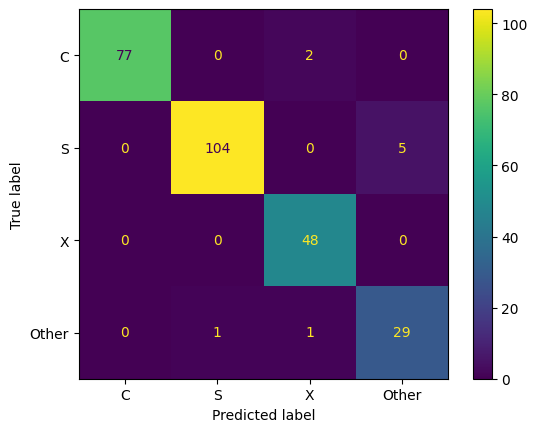

F1 Score: 0.967


In [ ]:
y_test_prop_pred = model.predict(X_test)

# Compute the corresponding one-hot classes
y_test_oh_pred = np.zeros_like(y_test_prop_pred)
y_test_oh_pred[np.arange(len(y_test_prop_pred)), y_test_prop_pred.argmax(1)] = 1

# Re-transform the classes now!
asteroid_classes_test = label_encoder.inverse_transform(y_test).reshape(1, -1)[0]
asteroid_classes_test_pred = label_encoder.inverse_transform(y_test_oh_pred).reshape(1, -1)[0]

# Compute the confusion matrix
conf_mat = confusion_matrix(asteroid_classes_test,
                            asteroid_classes_test_pred,
                            labels=["C", "S", "X", "Other"])

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=["C", "S", "X", "Other"])
disp.plot()
plt.show()

# A combined score
f1_score = round(sklearn.metrics.f1_score(asteroid_classes_test,
                                          asteroid_classes_test_pred,
                                          average="weighted"), 3)
print(f"F1 Score: {f1_score}")
